In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from scipy.interpolate import griddata
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import timeit

# Model and utilities

In [ ]:
class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name=None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name

    def sample(self, N):
        x = self.coords[0:1, :] + (self.coords[1:2, :] - self.coords[0:1, :]) * np.random.rand(N, self.dim)
        y = self.func(x)
        return x, y

In [ ]:
torch.manual_seed(0)

class LinearNeuralTangentKernel(torch.nn.Linear): 
    def __init__(self, in_features, out_features, bias=True, beta=1, w_sig=1):
        self.beta = beta
        super(LinearNeuralTangentKernel, self).__init__(in_features, out_features)
        self.reset_parameters()
        self.w_sig = w_sig / np.sqrt(self.out_features)
      
    def reset_parameters(self):
        # torch.nn.init.xavier_normal_(self.weight)
        torch.nn.init.normal_(self.weight, mean=0, std=1)
        if self.bias is not None:
            torch.nn.init.normal_(self.bias, mean=0, std=1)

    def forward(self, input):
        return F.linear(input, self.w_sig * self.weight, self.beta * self.bias) 

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}, beta={}'.format(
            self.in_features, self.out_features, self.bias is not None, self.beta
        )

class PINN(torch.nn.Module):
    def __init__(self, layers_width):
        super(PINN, self).__init__()
        # Initialize network weights and biases
        self.layers_width = layers_width
        self.initialize_NN()

    # Evaluates the forward pass
    def forward(self, H):
        num_layers = len(self.layers_width)
        for l in range(0, num_layers - 2):
            H = torch.tanh(self.layers[l](H))
        H = self.layers[-1](H)
        return H

     # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self):
        num_layers = len(self.layers_width)
        self.layers = torch.nn.ModuleList()
        for l in range(0, num_layers - 1):
            self.layers.append(LinearNeuralTangentKernel(self.layers_width[l], self.layers_width[l+1]))
        

class PINN_SOLVER:
    def __init__(self, X_u, Y_u, X_r, Y_r, params):

        # self.mu_X, self.sigma_X = X_r.mean(0), X_r.std(0)
        # self.mu_x, self.sigma_x = self.mu_X[0], self.sigma_X[0]
        self.N_u = X_u.shape[0]
        self.N_r = X_r.shape[0]

        # Normalize (may be better to normalize before feed the data into model), if needed
        # X_u_normalized = (X_u - self.mu_X) / self.sigma_X
        # X_r_normalized = (X_r - self.mu_X) / self.sigma_X
        self.X_u = X_u
        self.X_r = X_r
        self.Y_u = Y_u
        self.Y_r = Y_r
        self.X_u.requires_grad=True
        self.X_r.requires_grad=True

        # Initialize network 
        layers_width = params['layers_width']
        self.model = PINN(layers_width)
        
        # Logger
        # Loss logger
        self.loss_log = []
        self.loss_bcs_log = []
        self.loss_res_log = []

        # NTK logger 
        self.K_uu_log = []
        self.K_rr_log = []
        self.K_ur_log = []
        
        # Weights logger 
        self.weights_log = []
        self.biases_log = []

        self.loss_fnc = torch.nn.MSELoss()

        self.lambda_b = 1
        self.lambda_r = 1
        
        # training parameters
        epochs = params['epochs']
        starter_lr = params['lr']
        # gamma = params['gamma']
        # milestones = params['milestones']
        # momentum = params['momentum']
        # lr_lambda = params['lr_lambda']
        
        # Define optimizer with learning rate schedule
        self.optimizer = optim.SGD(self.model.parameters(),
                              lr=starter_lr)
        # self.optimizer = optim.Adam(self.model.parameters(),lr=0.005)
        # scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=milestones, gamma=gamma)
        # scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

    # Trains the model by minimizing the MSE loss
    def fit(self, log_NTK=False, log_weights=False, weighted_loss=False, quiet=False):
        self.model.train()

        start_time = timeit.default_timer()
        for iter in range(epochs):
            self.optimizer.zero_grad()

            # forward pass
            self.u_bc_pred = self.model(self.X_u)
            loss_bcs = self.loss_fnc(self.u_bc_pred, self.Y_u)
            self.loss_bcs_log.append(loss_bcs.data)

            # u_r_pred = self.model(X_r)
            # u_x = torch.autograd.grad(u_r_pred, X_r, torch.ones_like(u_r_pred), retain_graph=True, create_graph=True)[0] #/ self.sigma_X
            # self.u_xx = torch.autograd.grad(u_x, X_r, torch.ones_like(u_x), retain_graph=True, create_graph=True)[0] #/ self.sigma_X
            self.u_xx = self.compute_uxx(self.X_r)
            loss_res = self.loss_fnc(self.u_xx, self.Y_r)
            self.loss_res_log.append(loss_res.data)
            
            # Total loss
            loss = self.lambda_r*loss_res + self.lambda_b*loss_bcs    # need to tune the weights on each loss term
            self.loss_log.append(loss.data)

            # Print
            if iter % 1000 == 0:
                if not quiet:
                    elapsed = timeit.default_timer() - start_time
                    print('Epoch: %d, Loss: %.3e, Loss_bcs: %.3e, Loss_res: %.3e ,Time: %.2f' %
                          (iter, loss, loss_bcs, loss_res, elapsed))
                    
                    start_time = timeit.default_timer()

                if log_NTK:
                    # provide x, x' for NTK
                    # print("Compute NTK...")
                    Kuu, Krr, Kur = self.compute_ntk()
                    self.K_uu_log.append(Kuu)
                    self.K_ur_log.append(Kur)
                    self.K_rr_log.append(Krr)

                    if iter != 0 and weighted_loss:
                        K_trace = torch.trace(Kuu) + torch.trace(Krr)
                        self.lambda_b = K_trace/torch.trace(Kuu)
                        self.lambda_r = K_trace/torch.trace(Krr)
                      
                # if log_weights:
                #     print("Weights stored...")
                #     weights = self.sess.run(self.weights)
                #     biases = self.sess.run(self.biases)
                    
                #     self.weights_log.append(weights)
                #     self.biases_log.append(biases)

            # backpropagation
            loss.backward()
            self.optimizer.step()

        # plot loss history
        fig = plt.figure(figsize=(6,5))
        plt.plot(self.loss_res_log, label='$\mathcal{L}_{r}$')
        plt.plot(self.loss_bcs_log, label='$\mathcal{L}_{b}$')
        plt.yscale('log')
        plt.xlabel('iterations')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        plt.show()
                
    # Evaluates predictions at test points
    def predict_u(self, X_star):
        self.model.eval()
        with torch.no_grad():
          # X_star = (X_star - self.mu_X) / self.sigma_X
          u_star = self.model(X_star)
        return u_star

    def compute_uxx(self, X_r):
        u_r_pred = self.model(X_r)
        u_x = torch.autograd.grad(u_r_pred, X_r, torch.ones_like(u_r_pred), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, X_r, torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
        # u_xx.requires_grad = True
        return u_xx

    def compute_jacobian(self):
        Ju = []
        Jr = []
        for i in range(self.N_u):
            Ju.append(list_to_vector(torch.autograd.grad(self.u_bc_pred[i], self.model.parameters(), torch.ones_like(self.u_bc_pred[i]), retain_graph=True)))
        for i in range(self.N_r):
            Jri = torch.autograd.grad(self.u_xx[i], self.model.parameters(), torch.ones_like(self.u_xx[i]), allow_unused=True, retain_graph=True)
            Jri_list = []
            for j, param in enumerate(self.model.parameters()):
                if Jri[j] is not None:
                    Jri_list.append(Jri[j])
                else:
                    Jri_list.append(torch.zeros_like(param))
            Jr.append(list_to_vector(Jri_list))
        Ju = torch.vstack(Ju)
        Jr = torch.vstack(Jr)
        return Ju, Jr

    def compute_ntk(self):
        Ju, Jr = self.compute_jacobian()
        Kuu = Ju @ Ju.T
        Krr = Jr @ Jr.T
        Kur = Ju @ Jr.T
        # K1 = torch.hstack((Kuu, Kur))
        # K2 = torch.hstack((Kur.T, Krr))
        # K = torch.vstack((K1,K2))
        return Kuu, Krr, Kur


def list_to_vector(list_):
    return torch.cat([x.reshape(-1) for x in list_])

# def vector_to_list(vector):
#     list_ = []
#     counter = 0
#     for param in list(self.parameters()):
#         list_.append(vector[counter:counter+torch.numel(param)].view(param.shape))
#         counter += torch.numel(param)
#     return list_

In [ ]:
def plot_NTK_eigs(solver):
    # Create empty lists for storing the eigenvalues of NTK
    lambda_K_log = []
    lambda_K_uu_log = []
    lambda_K_ur_log = []
    lambda_K_rr_log = []

    # Restore the NTK
    K_uu_list = solver.K_uu_log
    K_ur_list = solver.K_ur_log
    K_rr_list = solver.K_rr_log
    K_list = []
        
    for k in range(len(K_uu_list)):
        K_uu = K_uu_list[k]
        K_ur = K_ur_list[k]
        K_rr = K_rr_list[k]
        
        K = np.concatenate([np.concatenate([K_uu, K_ur], axis = 1),
                            np.concatenate([K_ur.T, K_rr], axis = 1)], axis = 0)
        K_list.append(K)

        # Compute eigenvalues
        lambda_K, _ = np.linalg.eig(K)
        lambda_K_uu, _ = np.linalg.eig(K_uu)
        lambda_K_rr, _ = np.linalg.eig(K_rr)
        
        # Sort in descresing order
        lambda_K = np.sort(np.real(lambda_K))[::-1]
        lambda_K_uu = np.sort(np.real(lambda_K_uu))[::-1]
        lambda_K_rr = np.sort(np.real(lambda_K_rr))[::-1]
        
        # Store eigenvalues
        lambda_K_log.append(lambda_K)
        lambda_K_uu_log.append(lambda_K_uu)
        lambda_K_rr_log.append(lambda_K_rr)

    fig = plt.figure(figsize=(18, 5))
    plt.subplot(1,3,1)
    for i in range(1, len(lambda_K_log), 10):
        plt.plot(lambda_K_log[i], '--')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim
    plt.title(r'Eigenvalues of ${K}$')
    plt.tight_layout()

    plt.subplot(1,3,2)
    for i in range(1, len(lambda_K_uu_log), 10):
        plt.plot(lambda_K_uu_log[i], '--')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(r'Eigenvalues of ${K}_{uu}$')
    plt.tight_layout()

    plt.subplot(1,3,3)
    for i in range(1, len(lambda_K_log), 10):
        plt.plot(lambda_K_rr_log[i], '--')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(r'Eigenvalues of ${K}_{rr}$')
    plt.tight_layout()

    plt.show()

    return K_list, lambda_K_log


def plot_prediction(solver, u_fnc, u_xx_fnc):
    nn = 1000
    X_star = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
    u_star = u_fnc(X_star, a)
    r_star = u_xx_fnc(X_star, a)

    # convert to tensor
    X_star = torch.tensor(X_star).float()
    u_star = torch.tensor(u_star).float()
    r_star = torch.tensor(r_star).float()

    # Predictions
    u_pred = solver.predict_u(X_star)
    # r_pred = model.predict_r(X_star)
    error_u = torch.norm(u_star - u_pred, 2) / torch.norm(u_star, 2)
    # error_r = torch.norm(r_star - r_pred, 2) / torch.norm(r_star, 2)

    print('Relative L2 error_u: {:.2e}'.format(error_u))
    # print('Relative L2 error_r: {:.2e}'.format(error_r))

    fig = plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.plot(X_star, u_star, label='Exact')
    plt.plot(X_star, u_pred, '--', label='Predicted')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.legend(loc='upper right')

    plt.subplot(1,2,2)
    plt.plot(X_star, np.abs(u_star - u_pred), label='Error')
    plt.yscale('log')
    plt.xlabel('$x$')
    plt.ylabel('Point-wise error')
    plt.tight_layout()
    plt.show()

def plot_NTK_changes(K_list):
    # Change of the NTK
    NTK_change_list = []
    K0 = K_list[0]
    for K in K_list:
        diff = np.linalg.norm(K - K0) / np.linalg.norm(K0) 
        NTK_change_list.append(diff)

    fig = plt.figure(figsize=(6,5))
    plt.plot(NTK_change_list)

def plot_eigs_histogram(eigvals):
    plt.figure()
    plt.hist(eigvals, bins=50)
    # plt.ylim([0,10])
    plt.title("Eigenvalues of NTK")

# Experiments

In [ ]:
# Define solution and its Laplace
a = 0.5

# def u(x, a):
#   return np.sin(np.pi * a * x)

# def u_xx(x, a):
#   return -(np.pi * a)**2 * np.sin(np.pi * a * x)

# try two major frequencies
def u(x, a):
  return np.sin(np.pi * a * x) #+ np.sin(np.pi * 0.5 * x) + np.sin(np.pi * 2 * x)

def u_xx(x, a):
  return -(np.pi * a)**2 * np.sin(np.pi * a * x) #- (np.pi * 0.5)**2 * np.sin(np.pi * 0.5 * x) - (np.pi * 2)**2 * np.sin(np.pi * 2 * x)

# Define computional domain
bc1_coords = np.array([[0.0],
                       [0.0]])

bc2_coords = np.array([[1.0],
                       [1.0]])

dom_coords = np.array([[0.0],
                       [1.0]])

# Training data on u(x) -- Dirichlet boundary conditions

n  = 100

X_bc1 = dom_coords[0, 0] * np.ones((n // 2, 1))
X_bc2 = dom_coords[1, 0] * np.ones((n // 2, 1))
X_u = np.vstack([X_bc1, X_bc2])
Y_u = u(X_u, a)

X_r = np.linspace(dom_coords[0, 0], dom_coords[1, 0], n)[:, None]
Y_r = u_xx(X_r, a)

# convert to torch tensor
X_u = torch.tensor(X_u).float()
Y_u = torch.tensor(Y_u).float()
X_r = torch.tensor(X_r).float()
Y_r = torch.tensor(Y_r).float()

## Test width = 1024

In [ ]:
# Define model
layers_width = [1, 1024, 1]  
# layers_width = [1, 512, 512, 512, 1]
epochs = 40001
lr = 1e-5
# gamma = 0.8
# lr_lambda = lambda it: lr * gamma**(it/1000)

train_params = {
    'layers_width':     layers_width,
    'epochs':           epochs,
    'lr':               lr,
    # 'momentum':         0.9,
    # 'milestones':       [ms for ms in range(1,epochs) if ms%10000==0],
    # 'milestones':         [20000, 40000, 60000],
    # 'gamma':            gamma,
    # 'lr_lambda':        lr_lambda,
}

Epoch: 0, Loss: 4.821e+02, Loss_bcs: 4.790e+02, Loss_res: 3.135e+00 ,Time: 0.02
Epoch: 500, Loss: 3.186e+00, Loss_bcs: 9.988e-02, Loss_res: 3.086e+00 ,Time: 2.61
Epoch: 1000, Loss: 3.185e+00, Loss_bcs: 9.927e-02, Loss_res: 3.086e+00 ,Time: 2.94
Epoch: 1500, Loss: 3.184e+00, Loss_bcs: 9.866e-02, Loss_res: 3.086e+00 ,Time: 3.01
Epoch: 2000, Loss: 3.183e+00, Loss_bcs: 9.806e-02, Loss_res: 3.085e+00 ,Time: 3.47
Epoch: 2500, Loss: 3.183e+00, Loss_bcs: 9.746e-02, Loss_res: 3.085e+00 ,Time: 2.23
Epoch: 3000, Loss: 3.182e+00, Loss_bcs: 9.686e-02, Loss_res: 3.085e+00 ,Time: 1.66
Epoch: 3500, Loss: 3.181e+00, Loss_bcs: 9.626e-02, Loss_res: 3.085e+00 ,Time: 1.56
Epoch: 4000, Loss: 3.180e+00, Loss_bcs: 9.568e-02, Loss_res: 3.085e+00 ,Time: 1.53
Epoch: 4500, Loss: 3.180e+00, Loss_bcs: 9.509e-02, Loss_res: 3.084e+00 ,Time: 1.52
Epoch: 5000, Loss: 3.179e+00, Loss_bcs: 9.451e-02, Loss_res: 3.084e+00 ,Time: 1.51
Epoch: 5500, Loss: 3.178e+00, Loss_bcs: 9.393e-02, Loss_res: 3.084e+00 ,Time: 1.55
Epoch: 6

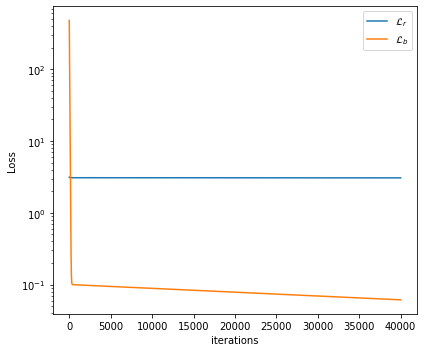

In [ ]:
solver = PINN_SOLVER(X_u, Y_u, X_r, Y_r, train_params)

# Train model
solver.fit(log_NTK=True,weighted_loss=False)

Relative L2 error_u: 3.06e-01


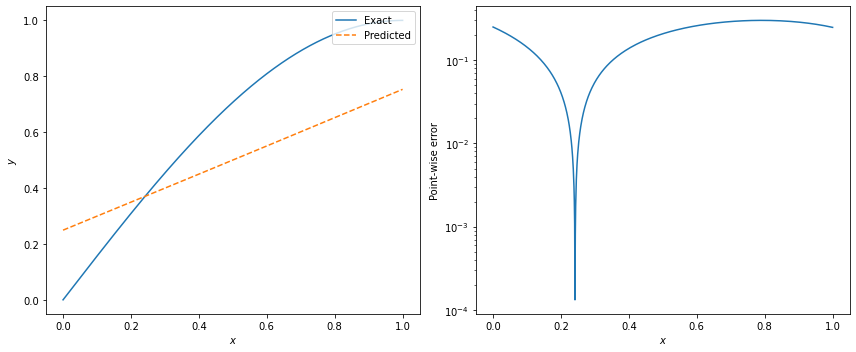

In [ ]:
plot_prediction(solver, u, u_xx)

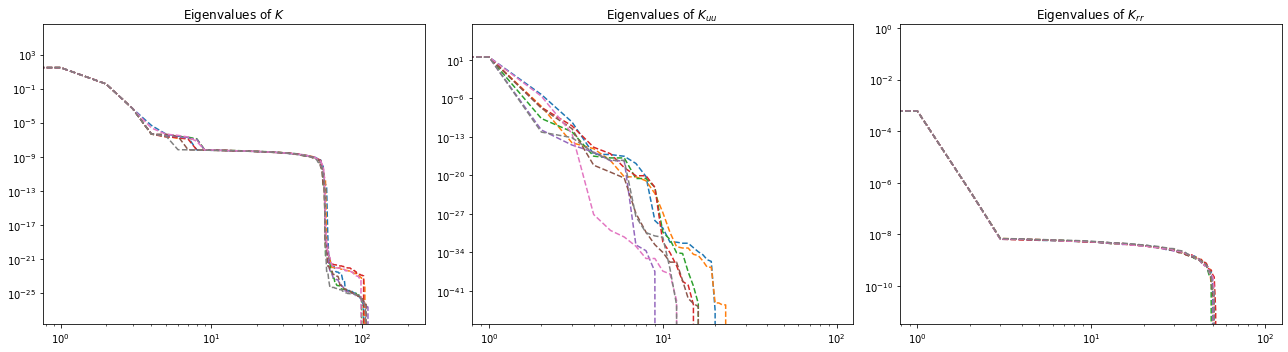

In [ ]:
K1024_list, eigs_K1024 = plot_NTK_eigs(solver)

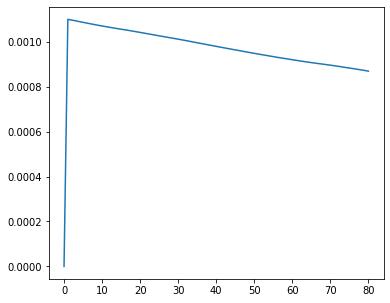

In [ ]:
plot_NTK_changes(K1024_list)

## Test width = 512

In [ ]:
# Define model
layers_width = [1, 512, 1]  
# layers_width = [1, 512, 512, 512, 1]
epochs = 80001
lr = 1e-5
# gamma = 0.8
# lr_lambda = lambda it: lr * gamma**(it/1000)

train_params = {
    'layers_width':     layers_width,
    'epochs':           epochs,
    'lr':               lr,
    # 'momentum':         0.9,
    # 'milestones':       [ms for ms in range(1,epochs) if ms%10000==0],
    # 'milestones':         [20000, 40000, 60000],
    # 'gamma':            gamma,
    # 'lr_lambda':        lr_lambda,
}

Epoch: 0, Loss: 1.120e+03, Loss_bcs: 3.077e+02, Loss_res: 8.120e+02 ,Time: 0.00
Epoch: 500, Loss: 8.118e+02, Loss_bcs: 1.834e-01, Loss_res: 8.116e+02 ,Time: 0.98
Epoch: 1000, Loss: 8.117e+02, Loss_bcs: 1.058e-01, Loss_res: 8.116e+02 ,Time: 1.12
Epoch: 1500, Loss: 8.117e+02, Loss_bcs: 1.055e-01, Loss_res: 8.116e+02 ,Time: 1.18
Epoch: 2000, Loss: 8.117e+02, Loss_bcs: 1.051e-01, Loss_res: 8.115e+02 ,Time: 1.07
Epoch: 2500, Loss: 8.116e+02, Loss_bcs: 1.048e-01, Loss_res: 8.115e+02 ,Time: 1.07
Epoch: 3000, Loss: 8.116e+02, Loss_bcs: 1.044e-01, Loss_res: 8.115e+02 ,Time: 1.04
Epoch: 3500, Loss: 8.116e+02, Loss_bcs: 1.041e-01, Loss_res: 8.115e+02 ,Time: 1.07
Epoch: 4000, Loss: 8.116e+02, Loss_bcs: 1.037e-01, Loss_res: 8.115e+02 ,Time: 1.07
Epoch: 4500, Loss: 8.116e+02, Loss_bcs: 1.034e-01, Loss_res: 8.115e+02 ,Time: 1.04
Epoch: 5000, Loss: 8.116e+02, Loss_bcs: 1.030e-01, Loss_res: 8.115e+02 ,Time: 1.49
Epoch: 5500, Loss: 8.116e+02, Loss_bcs: 1.027e-01, Loss_res: 8.115e+02 ,Time: 1.07
Epoch: 6

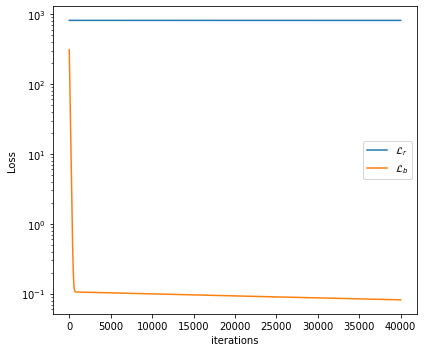

In [ ]:
solver_512 = PINN_SOLVER(X_u, Y_u, X_r, Y_r, train_params)

# Train model
solver_512.fit(log_NTK=True,weighted_loss=False)

Relative L2 error_u: 7.22e-01


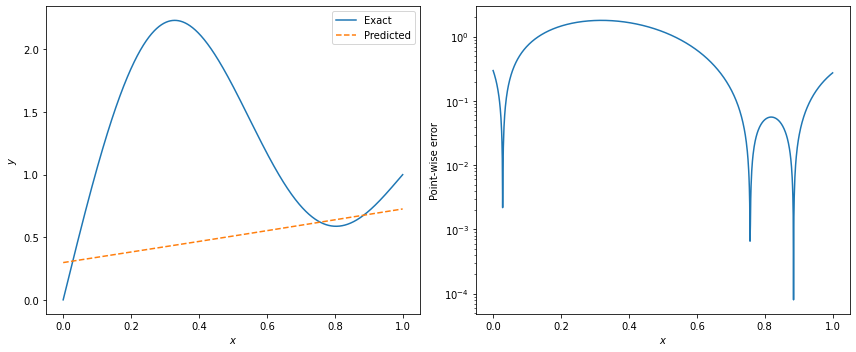

In [ ]:
plot_prediction(solver_512, u, u_xx)

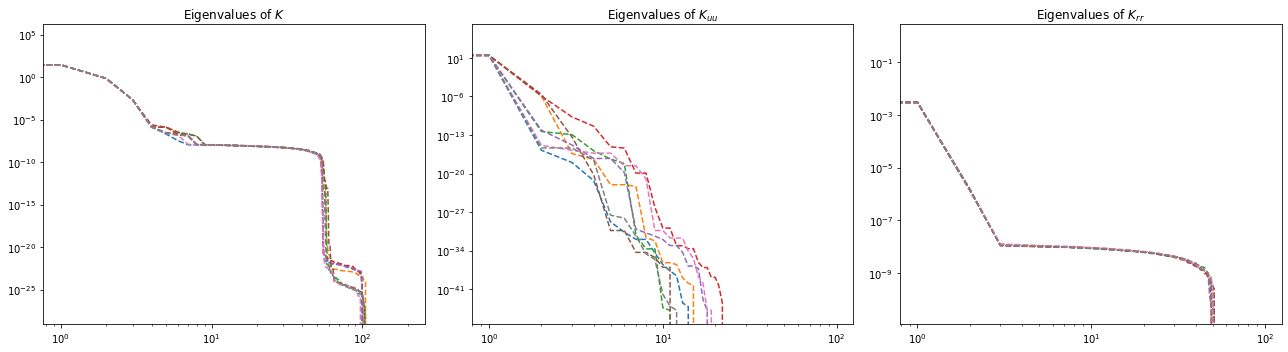

In [ ]:
K512_list, eigs_K512 = plot_NTK_eigs(solver_512)

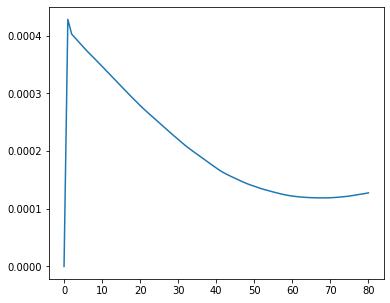

In [ ]:
plot_NTK_changes(K512_list)

In [ ]:
print(np.sort(abs(eigs_K512[0]))[::-1][:5])
print(np.sort(abs(eigs_K512[-1]))[::-1][:5])

[4.0855371e+04 2.8702066e+01 7.1864176e-01 2.1721472e-03 1.4944646e-06]
[4.0857691e+04 2.8503468e+01 7.2836691e-01 2.1365890e-03 1.2736998e-06]


In [ ]:
K512_uu_0 = torch.tensor(K512_list[0][:100,:100])
u_NTK = (torch.eye(K512_uu_0.shape[0]) - torch.linalg.matrix_exp(-K512_uu_0*100)) @ Y_u
print(torch.norm(u_NTK - Y_u))

K512_rr_0 = torch.tensor(K512_list[-1][100:,100:])
uxx_NTK = (torch.eye(K512_rr_0.shape[0]) - torch.linalg.matrix_exp(-K512_rr_0*1300000)) @ Y_r
print(torch.norm(uxx_NTK - Y_r))

tensor(0.0054)
tensor(1.9368)


In [ ]:
K512 = torch.tensor(K512_list[0])
U, S, V = torch.pca_lowrank(K512,q=2)
PCA_K512 = U @ torch.diag(S) @ V.T

PCA_K512_uu = PCA_K512[:100,:100]
u_PCA_NTK = (torch.eye(PCA_K512_uu.shape[0]) - torch.linalg.matrix_exp(-PCA_K512_uu*100)) @ Y_u
print(torch.norm(u_PCA_NTK - Y_u))

PCA_K512_rr = PCA_K512[100:,100:]
uxx_PCA_NTK = (torch.eye(PCA_K512_rr.shape[0]) - torch.linalg.matrix_exp(-PCA_K512_rr*100000)) @ Y_r
print(torch.norm(uxx_PCA_NTK - Y_r))

tensor(0.0007)
tensor(36.4865)


## Test width = 512 and weighted loss terms

Epoch: 0, Loss: 4.866e+01, Loss_bcs: 7.935e-02, Loss_res: 4.858e+01 ,Time: 0.00
Epoch: 1000, Loss: 4.863e+01, Loss_bcs: 6.198e-02, Loss_res: 4.857e+01 ,Time: 1.89
Epoch: 2000, Loss: 4.767e+05, Loss_bcs: 1.543e+02, Loss_res: 8.764e+00 ,Time: 1.97
Epoch: 3000, Loss: 1.428e+03, Loss_bcs: 5.207e+00, Loss_res: 8.572e+00 ,Time: 1.89
Epoch: 4000, Loss: 9.111e+02, Loss_bcs: 5.066e+00, Loss_res: 8.546e+00 ,Time: 1.95
Epoch: 5000, Loss: 8.417e+02, Loss_bcs: 4.919e+00, Loss_res: 8.523e+00 ,Time: 1.92
Epoch: 6000, Loss: 7.929e+02, Loss_bcs: 4.759e+00, Loss_res: 8.500e+00 ,Time: 1.86
Epoch: 7000, Loss: 7.527e+02, Loss_bcs: 4.595e+00, Loss_res: 8.477e+00 ,Time: 1.93
Epoch: 8000, Loss: 7.177e+02, Loss_bcs: 4.432e+00, Loss_res: 8.455e+00 ,Time: 1.84
Epoch: 9000, Loss: 6.864e+02, Loss_bcs: 4.271e+00, Loss_res: 8.433e+00 ,Time: 2.02
Epoch: 10000, Loss: 6.579e+02, Loss_bcs: 4.114e+00, Loss_res: 8.411e+00 ,Time: 1.83
Epoch: 11000, Loss: 6.318e+02, Loss_bcs: 3.961e+00, Loss_res: 8.389e+00 ,Time: 1.87
Epoch

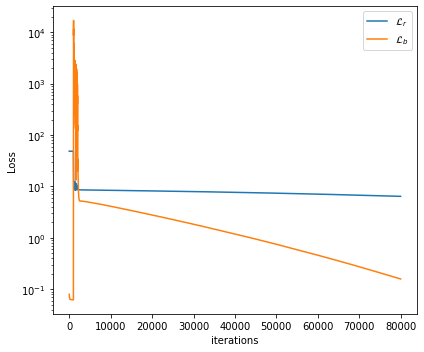

In [ ]:
solver_512 = PINN_SOLVER(X_u, Y_u, X_r, Y_r, train_params)

# Train model
solver_512.fit(log_NTK=True,weighted_loss=True)

Relative L2 error_u: 3.69e-01


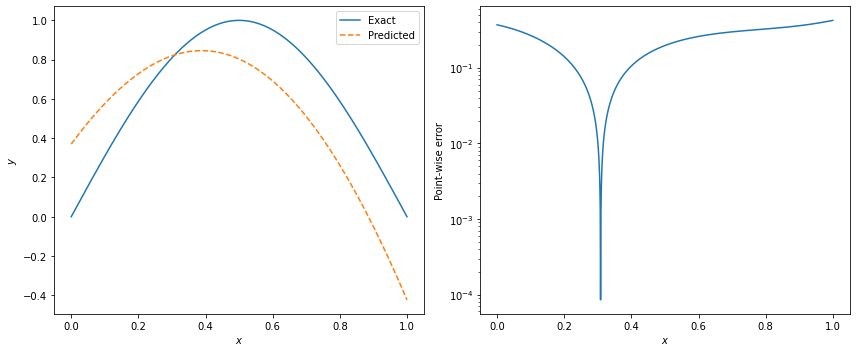

In [ ]:
plot_prediction(solver_512, u, u_xx)

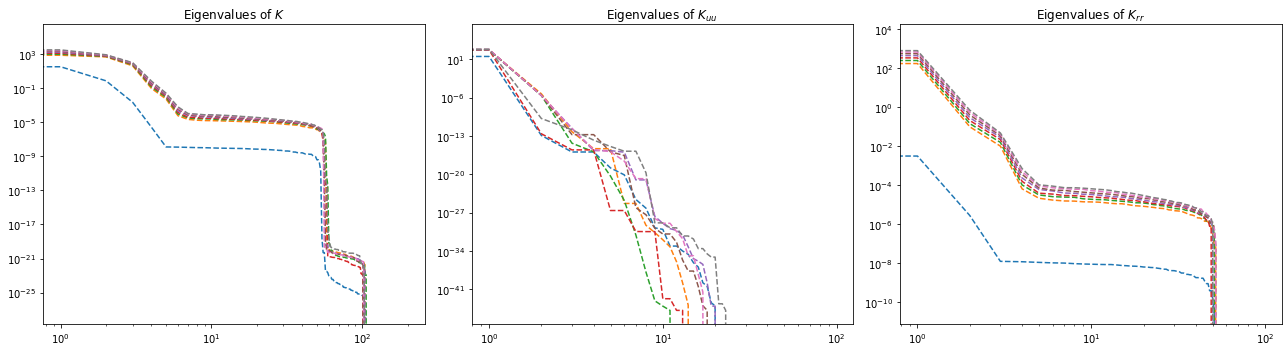

In [ ]:
K512_list, eigs_K512 = plot_NTK_eigs(solver_512)

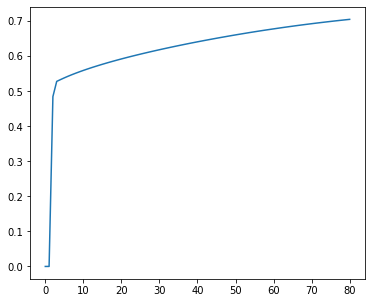

In [ ]:
plot_NTK_changes(K512_list)

In [ ]:
print(np.sort(abs(eigs_K512[0]))[::-1][:5])
print(np.sort(abs(eigs_K512[-1]))[::-1][:5])

[4.5635598e+04 3.2230923e+01 7.2160262e-01 2.2184509e-03 2.6163004e-06]
[7.6143172e+04 3.6417861e+03 8.7108246e+02 1.0329449e+02 8.3832753e-01]


## Test width = 100

In [ ]:
# Define model
layers_width = [1, 100, 1]  
epochs = 40001
lr = 1e-5
# gamma = 0.8
# lr_lambda = lambda it: lr * gamma**(it/1000)

train_params = {
    'layers_width':     layers_width,
    'epochs':           epochs,
    'lr':               lr,
    # 'momentum':         0.9,
    # 'milestones':       [ms for ms in range(1,epochs) if ms%10000==0],
    # 'milestones':         [20000, 40000, 60000],
    # 'gamma':            gamma,
    # 'lr_lambda':        lr_lambda,
}

Epoch: 0, Loss: 3.563e+01, Loss_bcs: 3.213e+01, Loss_res: 3.495e+00 ,Time: 0.00
Epoch: 500, Loss: 8.514e+00, Loss_bcs: 5.108e+00, Loss_res: 3.405e+00 ,Time: 0.63
Epoch: 1000, Loss: 4.163e+00, Loss_bcs: 7.955e-01, Loss_res: 3.367e+00 ,Time: 0.60
Epoch: 1500, Loss: 3.471e+00, Loss_bcs: 1.200e-01, Loss_res: 3.351e+00 ,Time: 0.63
Epoch: 2000, Loss: 3.360e+00, Loss_bcs: 1.679e-02, Loss_res: 3.343e+00 ,Time: 0.61
Epoch: 2500, Loss: 3.341e+00, Loss_bcs: 1.893e-03, Loss_res: 3.339e+00 ,Time: 0.59
Epoch: 3000, Loss: 3.337e+00, Loss_bcs: 9.954e-05, Loss_res: 3.336e+00 ,Time: 0.62
Epoch: 3500, Loss: 3.334e+00, Loss_bcs: 3.781e-05, Loss_res: 3.334e+00 ,Time: 0.60
Epoch: 4000, Loss: 3.332e+00, Loss_bcs: 1.165e-04, Loss_res: 3.332e+00 ,Time: 0.61
Epoch: 4500, Loss: 3.331e+00, Loss_bcs: 1.632e-04, Loss_res: 3.330e+00 ,Time: 0.58
Epoch: 5000, Loss: 3.329e+00, Loss_bcs: 1.842e-04, Loss_res: 3.329e+00 ,Time: 0.58
Epoch: 5500, Loss: 3.327e+00, Loss_bcs: 1.927e-04, Loss_res: 3.327e+00 ,Time: 0.57
Epoch: 6

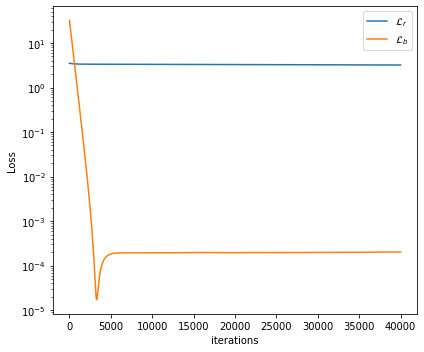

In [ ]:
solver = PINN_SOLVER(X_u, Y_u, X_r, Y_r, train_params)  

# Train model
solver.fit(log_NTK=True,weighted_loss=False)

Relative L2 error_u: 2.02e-01


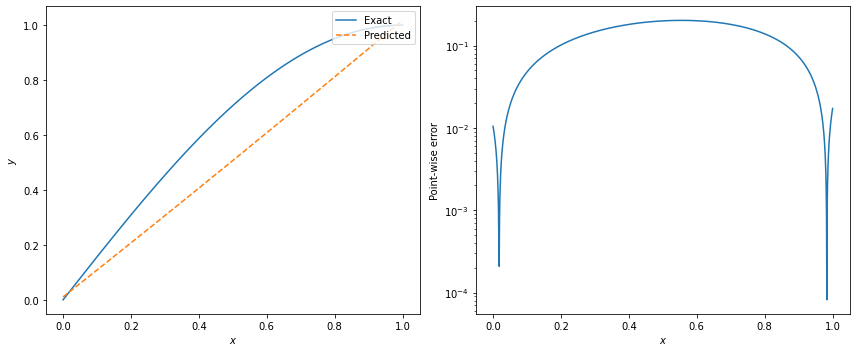

In [ ]:
plot_prediction(solver, u, u_xx)

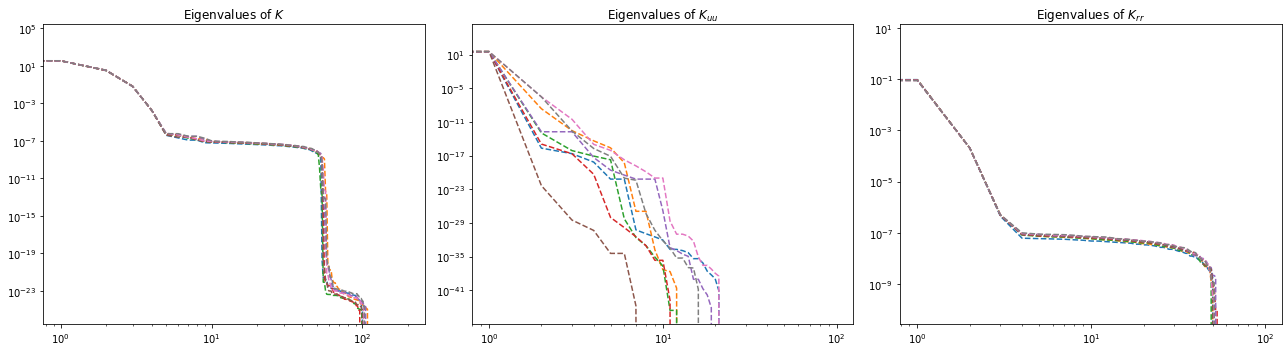

In [ ]:
K100_list, eigs_K100 = plot_NTK_eigs(solver)

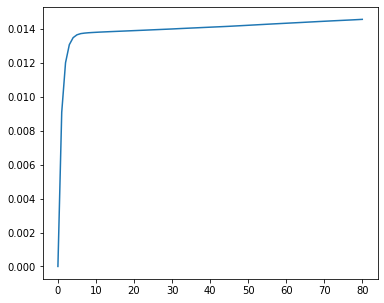

In [ ]:
plot_NTK_changes(K100_list)

## Test width = 10

In [ ]:
# Define model
layers_width = [1, 10, 1]  
epochs = 40001
lr = 1e-5
# gamma = 0.8
# lr_lambda = lambda it: lr * gamma**(it/1000)

train_params = {
    'layers_width':     layers_width,
    'epochs':           epochs,
    'lr':               lr,
    # 'momentum':         0.9,
    # 'milestones':       [ms for ms in range(1,epochs) if ms%10000==0],
    # 'milestones':         [20000, 40000, 60000],
    # 'gamma':            gamma,
    # 'lr_lambda':        lr_lambda,
}

Epoch: 0, Loss: 2.832e+00, Loss_bcs: 3.446e-01, Loss_res: 2.488e+00 ,Time: 0.00
Epoch: 500, Loss: 2.685e+00, Loss_bcs: 2.579e-01, Loss_res: 2.427e+00 ,Time: 0.54
Epoch: 1000, Loss: 2.566e+00, Loss_bcs: 1.935e-01, Loss_res: 2.373e+00 ,Time: 0.50
Epoch: 1500, Loss: 2.469e+00, Loss_bcs: 1.461e-01, Loss_res: 2.323e+00 ,Time: 0.51
Epoch: 2000, Loss: 2.389e+00, Loss_bcs: 1.118e-01, Loss_res: 2.278e+00 ,Time: 0.49
Epoch: 2500, Loss: 2.323e+00, Loss_bcs: 8.727e-02, Loss_res: 2.236e+00 ,Time: 0.51
Epoch: 3000, Loss: 2.268e+00, Loss_bcs: 7.013e-02, Loss_res: 2.198e+00 ,Time: 0.93
Epoch: 3500, Loss: 2.220e+00, Loss_bcs: 5.848e-02, Loss_res: 2.162e+00 ,Time: 0.51
Epoch: 4000, Loss: 2.180e+00, Loss_bcs: 5.088e-02, Loss_res: 2.129e+00 ,Time: 0.51
Epoch: 4500, Loss: 2.144e+00, Loss_bcs: 4.622e-02, Loss_res: 2.098e+00 ,Time: 0.50
Epoch: 5000, Loss: 2.113e+00, Loss_bcs: 4.366e-02, Loss_res: 2.069e+00 ,Time: 0.50
Epoch: 5500, Loss: 2.085e+00, Loss_bcs: 4.258e-02, Loss_res: 2.042e+00 ,Time: 0.50
Epoch: 6

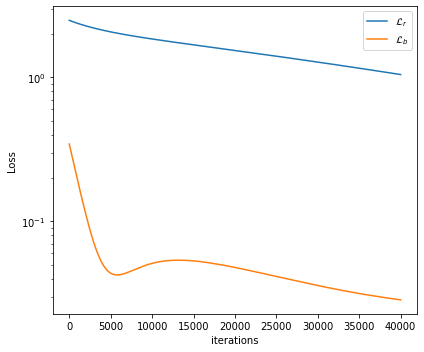

In [ ]:
solver = PINN_SOLVER(X_u, Y_u, X_r, Y_r, train_params)  

# Train model
solver.fit(log_NTK=True,weighted_loss=False)

Relative L2 error_u: 1.44e-01


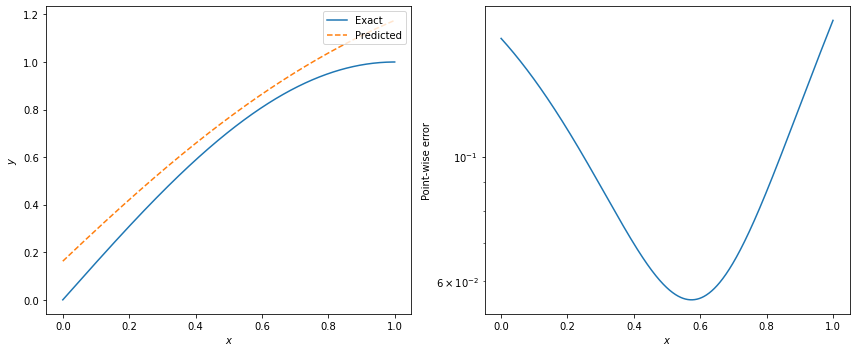

In [ ]:
plot_prediction(solver, u, u_xx)

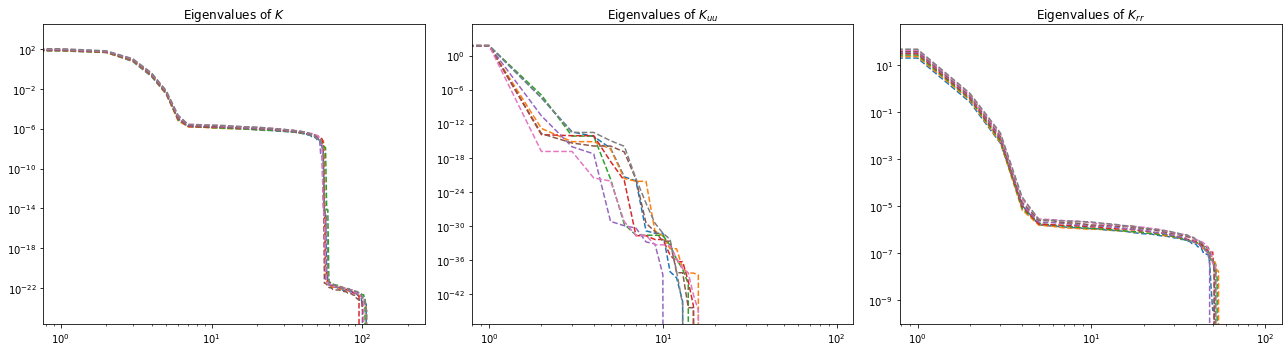

In [ ]:
K10_list, eigs_K10 = plot_NTK_eigs(solver)

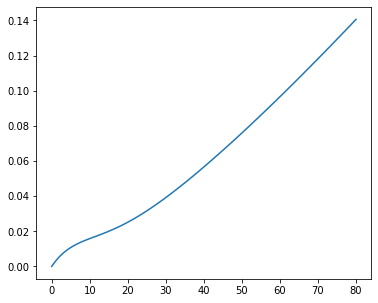

In [ ]:
plot_NTK_changes(K10_list)

## Test bigger learning rate

In [ ]:
# Define model
layers_width = [1, 512, 1]  
epochs = 40001
lr = 1e-3
# gamma = 0.8
# lr_lambda = lambda it: lr * gamma**(it/1000)

train_params = {
    'layers_width':     layers_width,
    'epochs':           epochs,
    'lr':               lr,
    # 'momentum':         0.9,
    # 'milestones':       [ms for ms in range(1,epochs) if ms%10000==0],
    # 'milestones':         [20000, 40000, 60000],
    # 'gamma':            gamma,
    # 'lr_lambda':        lr_lambda,
}

Epoch: 0, Loss: 3.846e+01, Loss_bcs: 3.540e+01, Loss_res: 3.058e+00 ,Time: 0.00
Epoch: 500, Loss: 3.295e+00, Loss_bcs: 2.433e-01, Loss_res: 3.051e+00 ,Time: 0.99
Epoch: 1000, Loss: 3.138e+00, Loss_bcs: 1.270e-01, Loss_res: 3.011e+00 ,Time: 1.01
Epoch: 1500, Loss: 3.037e+00, Loss_bcs: 6.592e-02, Loss_res: 2.971e+00 ,Time: 0.92
Epoch: 2000, Loss: 2.966e+00, Loss_bcs: 3.395e-02, Loss_res: 2.932e+00 ,Time: 1.00
Epoch: 2500, Loss: 2.911e+00, Loss_bcs: 1.727e-02, Loss_res: 2.894e+00 ,Time: 0.98
Epoch: 3000, Loss: 2.865e+00, Loss_bcs: 8.640e-03, Loss_res: 2.857e+00 ,Time: 1.02
Epoch: 3500, Loss: 2.825e+00, Loss_bcs: 4.221e-03, Loss_res: 2.821e+00 ,Time: 1.01
Epoch: 4000, Loss: 2.788e+00, Loss_bcs: 1.997e-03, Loss_res: 2.786e+00 ,Time: 0.98
Epoch: 4500, Loss: 2.753e+00, Loss_bcs: 9.046e-04, Loss_res: 2.752e+00 ,Time: 0.99
Epoch: 5000, Loss: 2.719e+00, Loss_bcs: 3.854e-04, Loss_res: 2.719e+00 ,Time: 0.96
Epoch: 5500, Loss: 2.686e+00, Loss_bcs: 1.502e-04, Loss_res: 2.686e+00 ,Time: 0.99
Epoch: 6

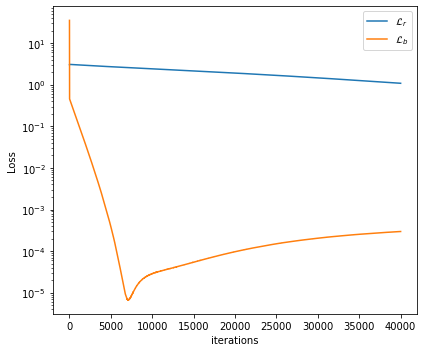

In [ ]:
solver = PINN_SOLVER(X_u, Y_u, X_r, Y_r, train_params)  

# Train model
solver.fit(log_NTK=True,weighted_loss=False)

Relative L2 error_u: 1.01e-01


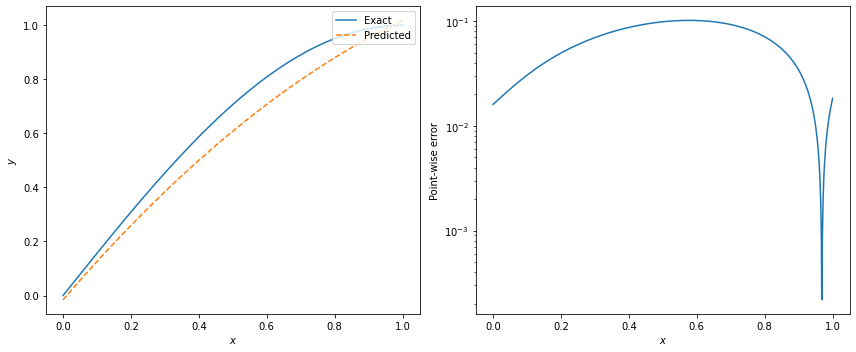

In [ ]:
plot_prediction(solver, u, u_xx)

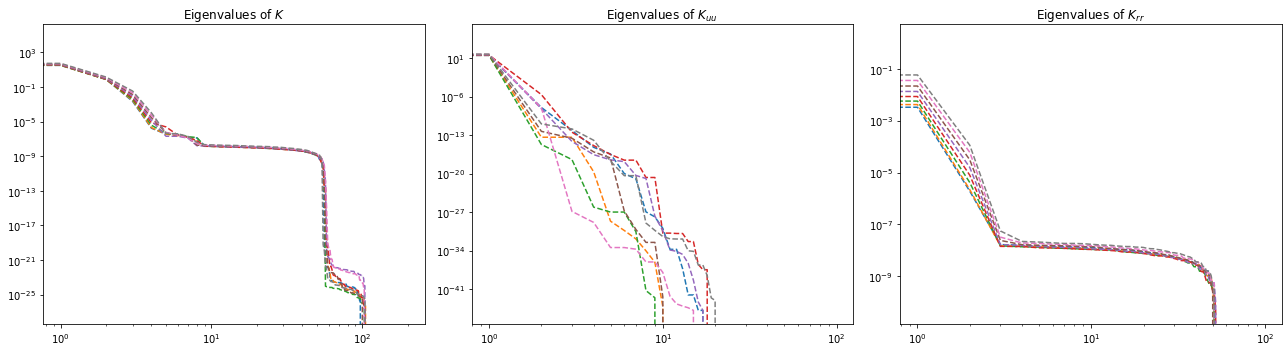

In [ ]:
K_large_lr_list, eigs_K_large_lr = plot_NTK_eigs(solver)

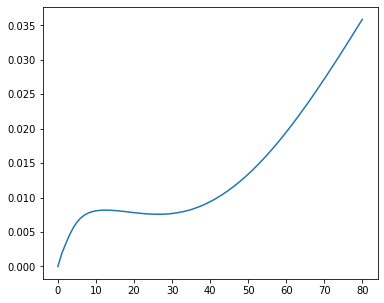

In [ ]:
plot_NTK_changes(K_large_lr_list)

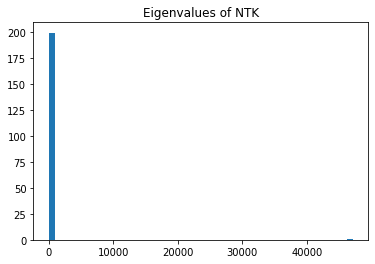

In [ ]:
plot_eigs_histogram(eigs_K_large_lr[-1])